In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve, average_precision_score, PrecisionRecallDisplay, recall_score, f1_score, precision_recall_curve, auc, classification_report, confusion_matrix, make_scorer, fbeta_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
import shap
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

In [25]:
df_train=pd.read_csv('../data/output/development_sample_cleaned_1.csv')
df_test=pd.read_csv('../data/output/testing_sample_cleaned.csv')

In [26]:
df_train = df_train.drop(['ID', 'customer_id'], axis=1)
df_test = df_test.drop(['ID', 'customer_id'], axis=1)

In [27]:
df_train=pd.read_csv('../data/output/categorical_dfs/development_sample_cleaned_categorical.csv')
df_test=pd.read_csv('../data/output/categorical_dfs/testing_sample_cleaned_categorical.csv')

In [28]:
df_train=pd.read_csv('../data/output/categorical_dfs/development_sample_woe.csv')
df_test=pd.read_csv('../data/output/categorical_dfs/testing_sample_woe.csv')

In [29]:
# Separate features and target variable
X = df_train.drop('target', axis=1)
y = df_train['target']
X_t = df_test.drop('target', axis=1)
y_t = df_test['target']

In [30]:
oversamplers = {
    #'SMOTE': SMOTE(random_state=123),
    #'RandomOverSampler': RandomOverSampler(random_state=123)
    #'ADASYN': ADASYN(random_state=123),
    'RandomUnderSampler': RandomUnderSampler(random_state=123)
    #'NearMiss': NearMiss(version=1, n_neighbors=3)
}

In [31]:
models = {
    'Random Forest': RandomForestClassifier(random_state=123),
    'XGBoost': XGBClassifier(random_state=123, n_jobs=-1, objective='binary:logistic'),
    'LightGBM': LGBMClassifier(random_state=123),
    'SVC': SVC(probability=True, random_state=123),
    'CatBoost': CatBoostClassifier(random_state=123, verbose=0),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=123)
}

# Define parameter grids for each model
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'learning_rate': [0.04, 0.05, 0.6],
    'n_estimators': [60,80,100],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

param_grid_lgbm = {
    'learning_rate': [0.04, 0.05, 0.6],
    'n_estimators': [60,80, 100],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

param_grid_svc = {
    'C': [0.9,1,1.1],
    'gamma': [0.1, 1, 'scale', 'auto']
}

param_grid_catboost = {
    'iterations': [60,80, 100],
    'learning_rate': [0.005,0.01],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'auto_class_weights': ['None', 'Balanced'],
}

param_grid_knn = {
    'n_neighbors': [9,14,17,20],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

param_grid_logreg = {
    'C': [ 0.09, 0.1, 1.1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

In [32]:
rus = RandomUnderSampler(random_state=123)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_t_scaled = scaler.transform(X_t)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y)

In [19]:
plt.figure(figsize=(16, 10))
for i, (name, model) in enumerate(models.items(), 1):
    print(f"\nTraining model: {name}")
    
    # Initialize GridSearchCV with the model and its parameter grid
    if name == 'Random Forest':
        grid_search = GridSearchCV(model, param_grid_rf, cv=3, scoring='f1_score', n_jobs=-1, verbose=0)
    elif name == 'XGBoost':
        grid_search = GridSearchCV(model, param_grid_xgb, cv=3, scoring='f1_score', n_jobs=-1, verbose=0)
    elif name == 'LightGBM':
        grid_search = GridSearchCV(model, param_grid_lgbm, cv=3, scoring='f1_score', n_jobs=-1, verbose=0)
    elif name == 'SVC':
        grid_search = GridSearchCV(model, param_grid_svc, cv=3, scoring='f1_score', n_jobs=-1, verbose=0)
    elif name == 'CatBoost':
        grid_search = GridSearchCV(model, param_grid_catboost, cv=3, scoring='f1_score', n_jobs=-1, verbose=0)
    elif name == 'KNN':
        grid_search = GridSearchCV(model, param_grid_knn, cv=3, scoring='f1_score', n_jobs=-1, verbose=0)
    elif name == 'Logistic Regression':
        grid_search = GridSearchCV(model, param_grid_logreg, cv=3, scoring='f1_score', n_jobs=-1, verbose=0)

    # Fit GridSearchCV on the down-sampled data
    grid_search.fit(X_resampled, y_resampled)
    
    # Get the best parameters
    best_params = grid_search.best_params_
    
    # Get the best performing model
    best_model = model.set_params(**best_params)
    best_model.fit(X_resampled, y_resampled)
    
    # Calculate AUC-ROC
    y_prob = best_model.predict_proba(X_t_scaled)[:, 1]
    auc_roc = roc_auc_score(y_t, y_prob)
    
    # Print classification report
    print("\nClassification Report:")
    y_pred = best_model.predict(X_t_scaled)
    print(classification_report(y_t, y_pred))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_t, y_pred)
    plt.subplot(2, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {name}\nAUC-ROC Score: {auc_roc:.3f}')
    
    # Plot AUC-ROC Curve
    fpr, tpr, _ = roc_curve(y_t, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_roc:.3f})')
    
plt.tight_layout()
plt.show()


Training model: Random Forest


ValueError: 'f1_score' is not a valid scoring value. Use sklearn.metrics.get_scorer_names() to get valid options.

<Figure size 1600x1000 with 0 Axes>

In [9]:
plt.figure(figsize=(16, 10))
for i, (name, model) in enumerate(models.items(), 1):
    print(f"\nTraining model: {name}")
    
    # Initialize GridSearchCV with the model and its parameter grid
    if name == 'Random Forest':
        grid_search = GridSearchCV(model, param_grid_rf, cv=3, scoring='auc_roc', n_jobs=-1, verbose=0)
    elif name == 'XGBoost':
        grid_search = GridSearchCV(model, param_grid_xgb, cv=3, scoring='auc_roc', n_jobs=-1, verbose=0)
    elif name == 'LightGBM':
        grid_search = GridSearchCV(model, param_grid_lgbm, cv=3, scoring='auc_roc', n_jobs=-1, verbose=0)
    elif name == 'SVC':
        grid_search = GridSearchCV(model, param_grid_svc, cv=3, scoring='auc_roc', n_jobs=-1, verbose=0)
    elif name == 'CatBoost':
        grid_search = GridSearchCV(model, param_grid_catboost, cv=3, scoring='auc_roc', n_jobs=-1, verbose=0)
    elif name == 'KNN':
        grid_search = GridSearchCV(model, param_grid_knn, cv=3, scoring='auc_roc', n_jobs=-1, verbose=0)
    elif name == 'Logistic Regression':
        grid_search = GridSearchCV(model, param_grid_logreg, cv=3, scoring='auc_roc', n_jobs=-1, verbose=0)
    
    # Fit GridSearchCV on the down-sampled data
    grid_search.fit(X_resampled, y_resampled)
    
    # Get the best parameters
    best_params = grid_search.best_params_
    
    # Get the best performing model
    best_model = model.set_params(**best_params)
    best_model.fit(X_resampled, y_resampled)
    
    # Calculate AUC-ROC
    y_prob = best_model.predict_proba(X_t_scaled)[:, 1]
    auc_roc = roc_auc_score(y_t, y_prob)
    
    # Print classification report
    print("\nClassification Report:")
    y_pred = best_model.predict(X_t_scaled)
    print(classification_report(y_t, y_pred))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_t, y_pred)
    plt.subplot(3, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {name}\nAUC-ROC Score: {auc_roc:.3f}')
    
    # Plot AUC-ROC Curve
    fpr, tpr, _ = roc_curve(y_t, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_roc:.3f})')
    
plt.tight_layout()
plt.show()


Training model: Random Forest


ValueError: 'auc_roc' is not a valid scoring value. Use sklearn.metrics.get_scorer_names() to get valid options.

<Figure size 1600x1000 with 0 Axes>


Training model: Random Forest

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92      3427
         1.0       0.10      0.44      0.17       119

    accuracy                           0.85      3546
   macro avg       0.54      0.65      0.54      3546
weighted avg       0.95      0.85      0.89      3546


Training model: XGBoost

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88      3427
         1.0       0.08      0.53      0.14       119

    accuracy                           0.79      3546
   macro avg       0.53      0.66      0.51      3546
weighted avg       0.95      0.79      0.85      3546


Training model: LightGBM

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.79      0.88      3427
         1.0       0.08      0.54      0.14       119

    accuracy                

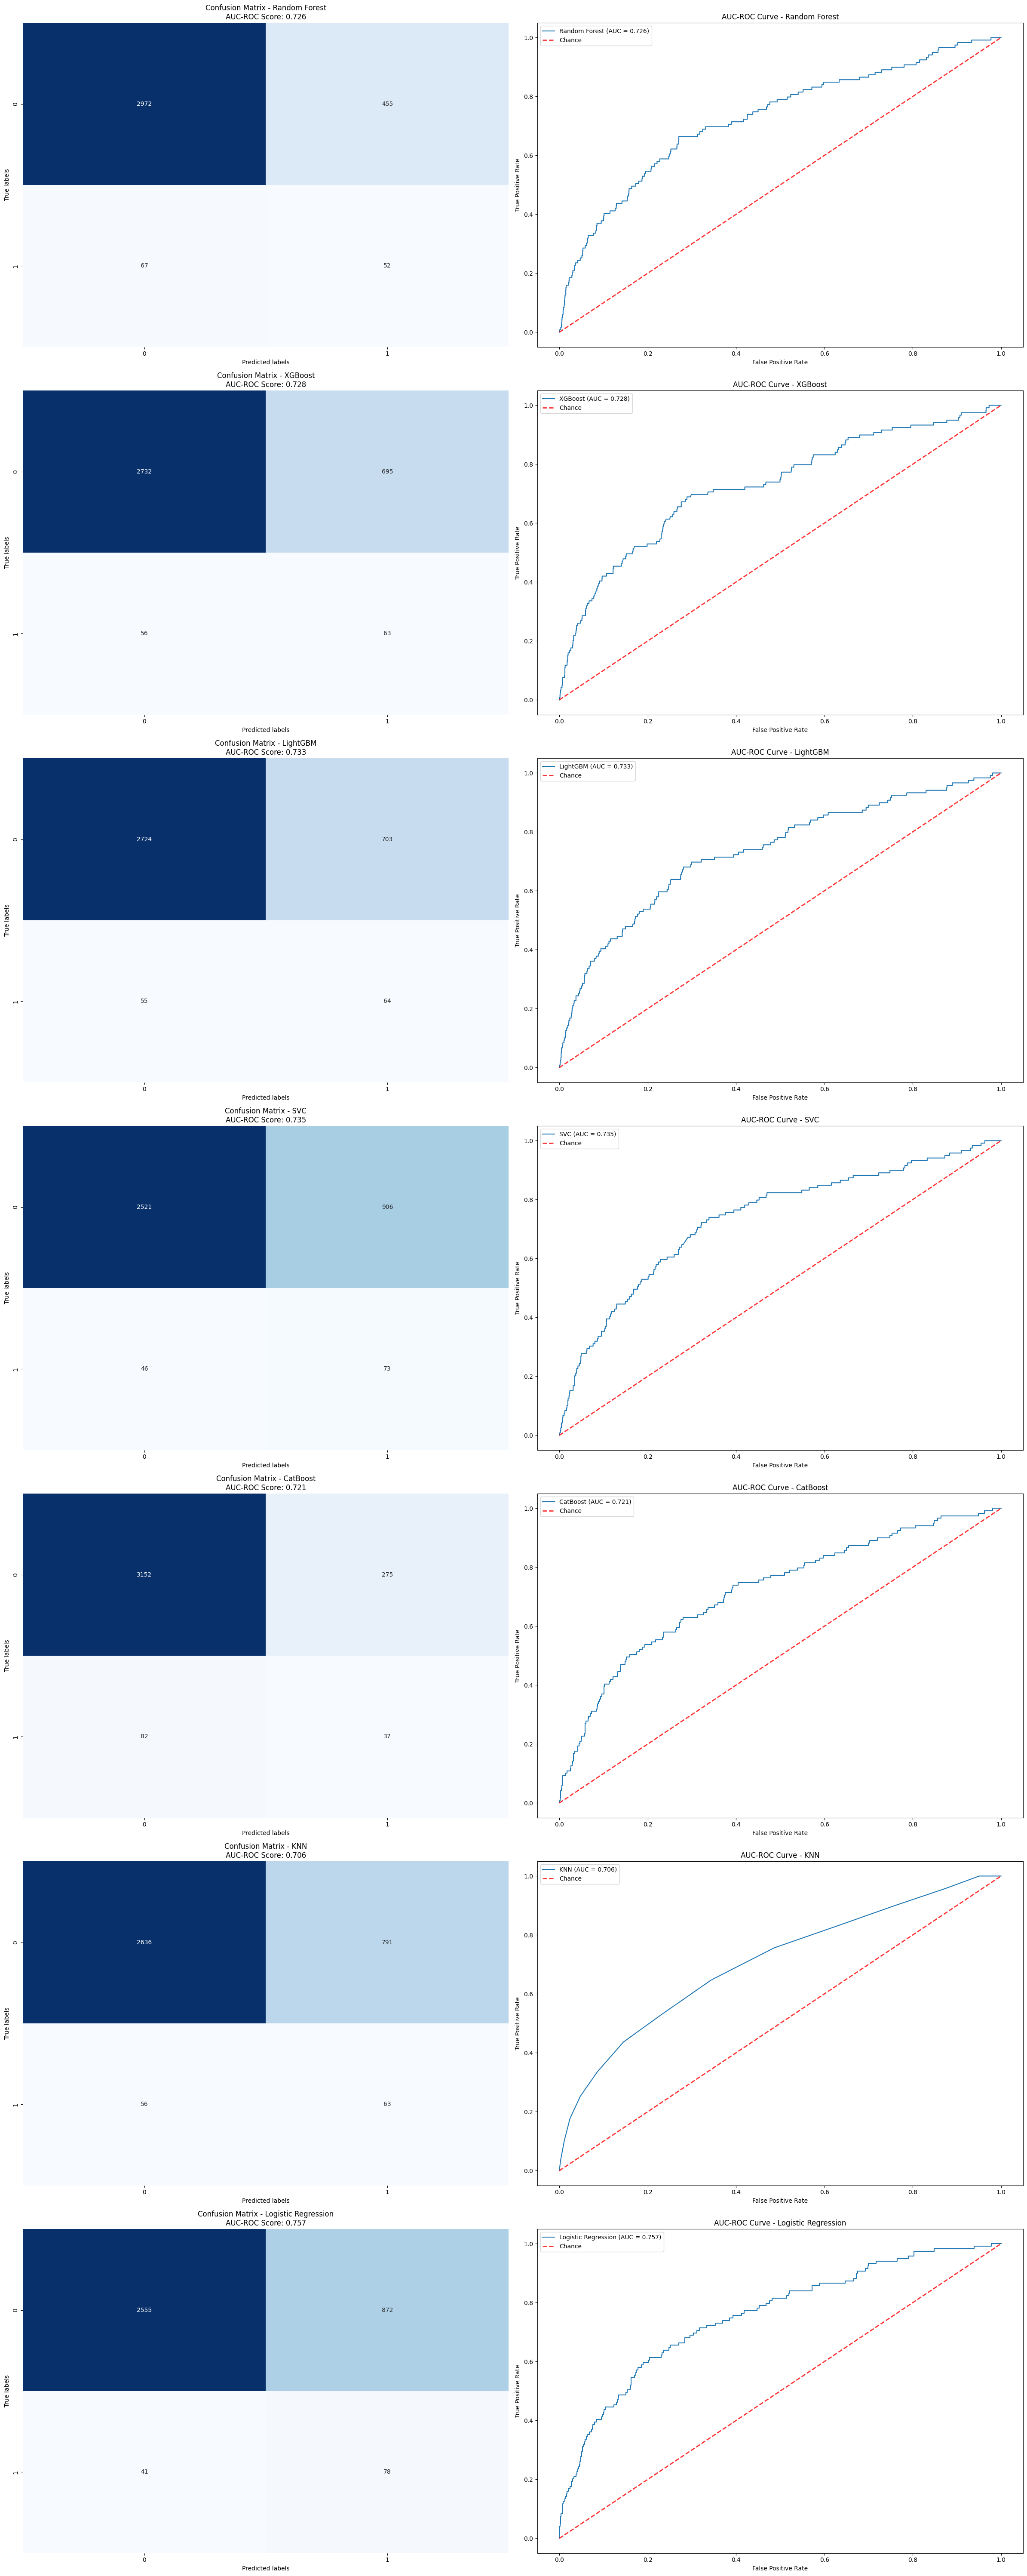


Calculating SHAP values for Random Forest


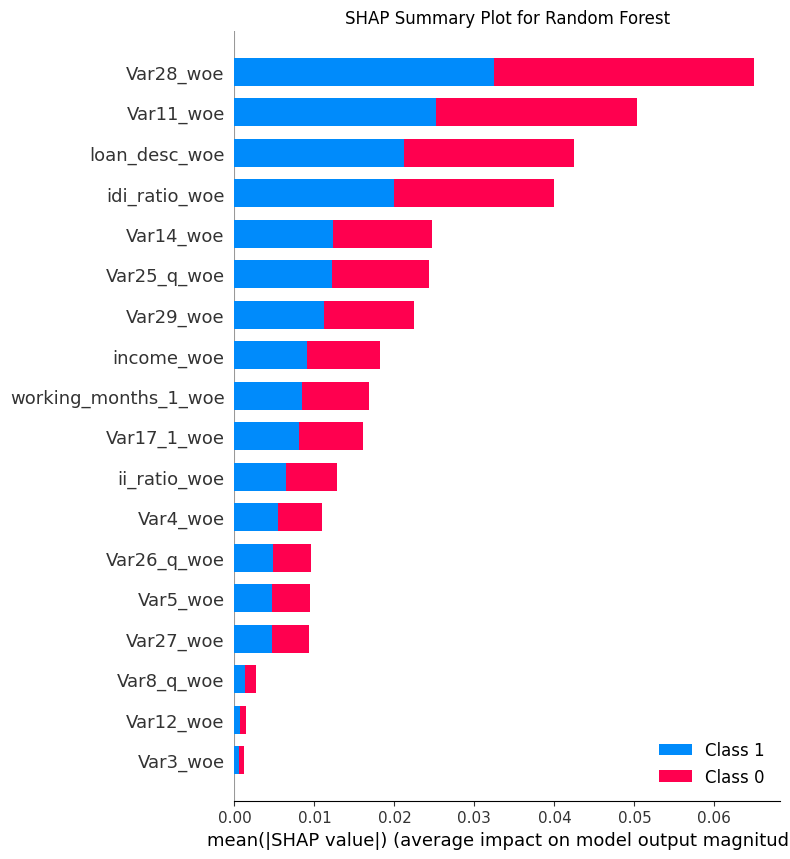


Calculating SHAP values for XGBoost


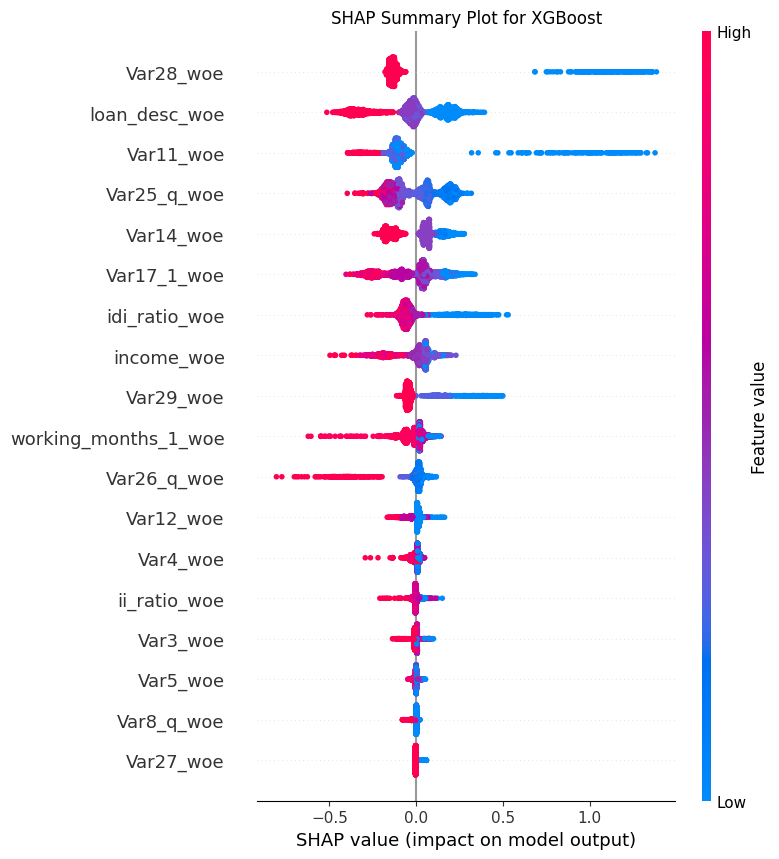


Calculating SHAP values for LightGBM


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


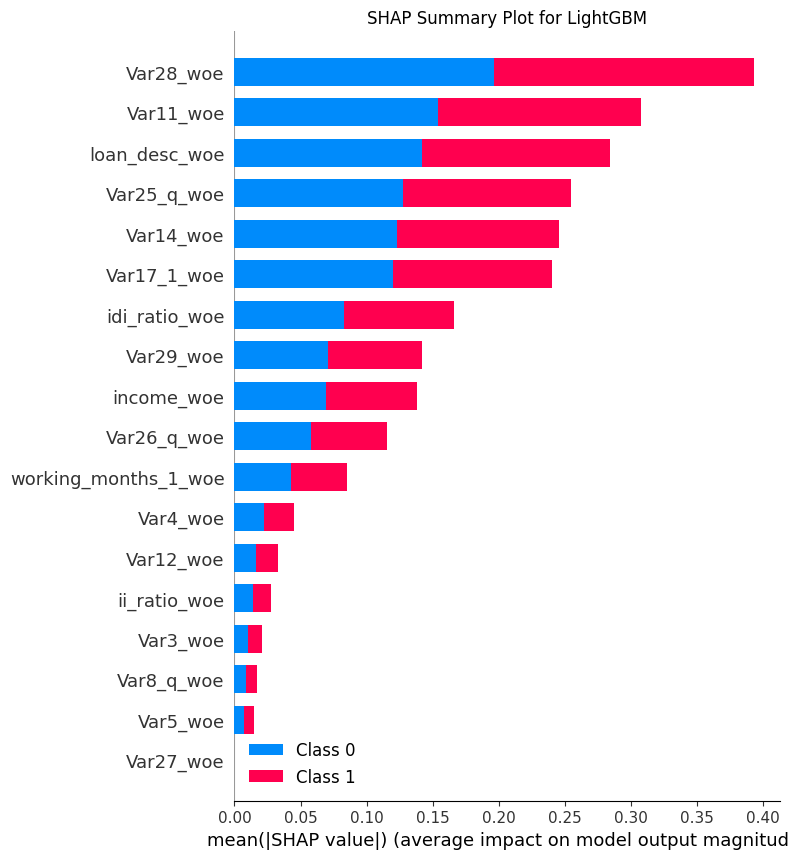


Calculating SHAP values for SVC
No SHAP for SVC

Calculating SHAP values for CatBoost


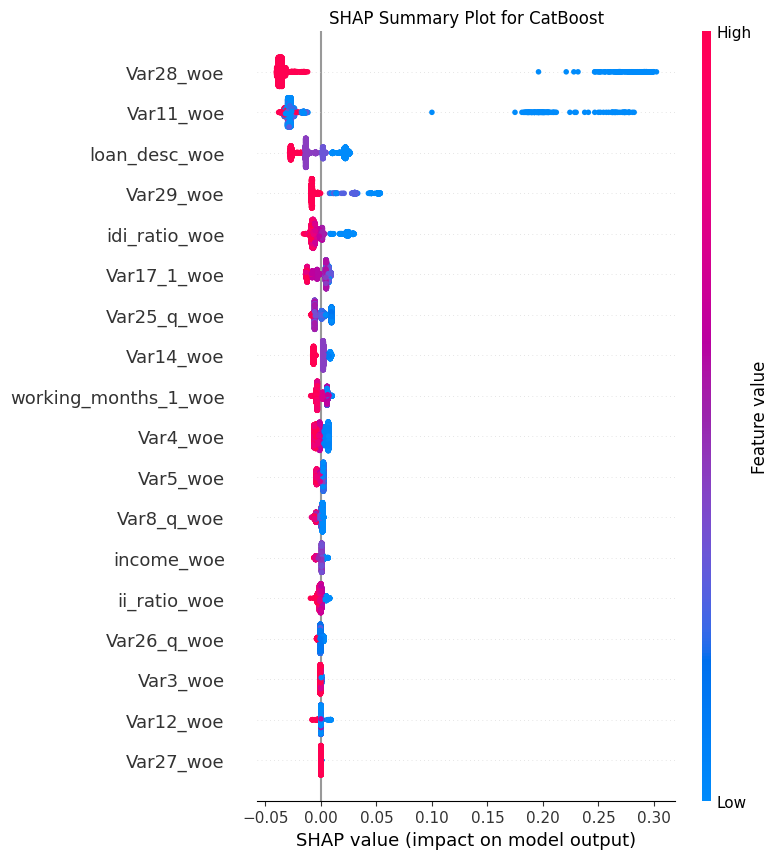


Calculating SHAP values for KNN
No SHAP for KNN

Calculating SHAP values for Logistic Regression


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._logistic.LogisticRegression'>

In [33]:
from sklearn.model_selection import cross_val_score
from IPython.display import display
results = []
best_models = {} 
plt.figure(figsize=(24, 60))
for i, (name, model) in enumerate(models.items(), 1):
    print(f"\nTraining model: {name}")
    
    # Initialize GridSearchCV with the model and its parameter grid
    if name == 'Random Forest':
        grid_search = GridSearchCV(model, param_grid_rf, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    elif name == 'XGBoost':
        grid_search = GridSearchCV(model, param_grid_xgb, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    elif name == 'LightGBM':
        grid_search = GridSearchCV(model, param_grid_lgbm, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    elif name == 'SVC':
        grid_search = GridSearchCV(model, param_grid_svc, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    elif name == 'CatBoost':
        grid_search = GridSearchCV(model, param_grid_catboost, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    elif name == 'KNN':
        grid_search = GridSearchCV(model, param_grid_knn, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    elif name == 'Logistic Regression':
        grid_search = GridSearchCV(model, param_grid_logreg, cv=5, scoring='precision', n_jobs=-1, verbose=0)
    
    # Fit GridSearchCV on the down-sampled data
    grid_search.fit(X_resampled, y_resampled)
    
    # Get the best parameters
    best_params = grid_search.best_params_
    
    # Get the best performing model
    best_model = model.set_params(**best_params)
    best_model.fit(X_resampled, y_resampled)
    
    best_models[name] = best_model
    # Calculate AUC-ROC
    y_prob = best_model.predict_proba(X_t_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_t, y_prob)
    auc_roc = roc_auc_score(y_t, y_prob)
    
    # Print classification report
    print("\nClassification Report:")
    y_pred = best_model.predict(X_t_scaled)
    print(classification_report(y_t, y_pred))
    
    # Plot Confusion Matrix
    plt.subplot(7, 2, 2*i-1)
    cm = confusion_matrix(y_t, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {name}\nAUC-ROC Score: {auc_roc:.3f}')
    
    # Plot AUC-ROC Curve
    plt.subplot(7, 2, 2*i)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_roc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUC-ROC Curve - {name}')
    plt.legend()

    # Calculate cross-validated score
    cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=3, scoring='roc_auc')
    cv_score_mean = cv_scores.mean()
    
    # Calculate final test score
    test_score = roc_auc_score(y_t, y_prob)
    
    # Save results to list
    results.append({
        'Model_name': name,
        'Parameters': str(best_params),
        'CV_score': cv_score_mean,
        'Test_score': test_score
    })

    

plt.tight_layout()
plt.show()

for name, best_model in best_models.items():
    print(f"\nCalculating SHAP values for {name}")
    if name == 'SVC':
        print('No SHAP for SVC')
    elif name == 'KNN':
        print('No SHAP for KNN')
    else:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_t_scaled)
    
        # Plot SHAP summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_t_scaled, feature_names=X.columns, show=False)
        plt.title(f'SHAP Summary Plot for {name}')
        plt.tight_layout()
        plt.show()

# Create DataFrame from results and display
results_df = pd.DataFrame(results)
print("\nResults Table:")
display(results_df)





Training model: Random Forest

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87      3427
         1.0       0.09      0.58      0.15       119

    accuracy                           0.78      3546
   macro avg       0.53      0.68      0.51      3546
weighted avg       0.95      0.78      0.85      3546


Training model: XGBoost

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      3427
         1.0       0.08      0.59      0.14       119

    accuracy                           0.76      3546
   macro avg       0.53      0.68      0.50      3546
weighted avg       0.95      0.76      0.84      3546


Training model: LightGBM

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85      3427
         1.0       0.08      0.63      0.14       119

    accuracy                

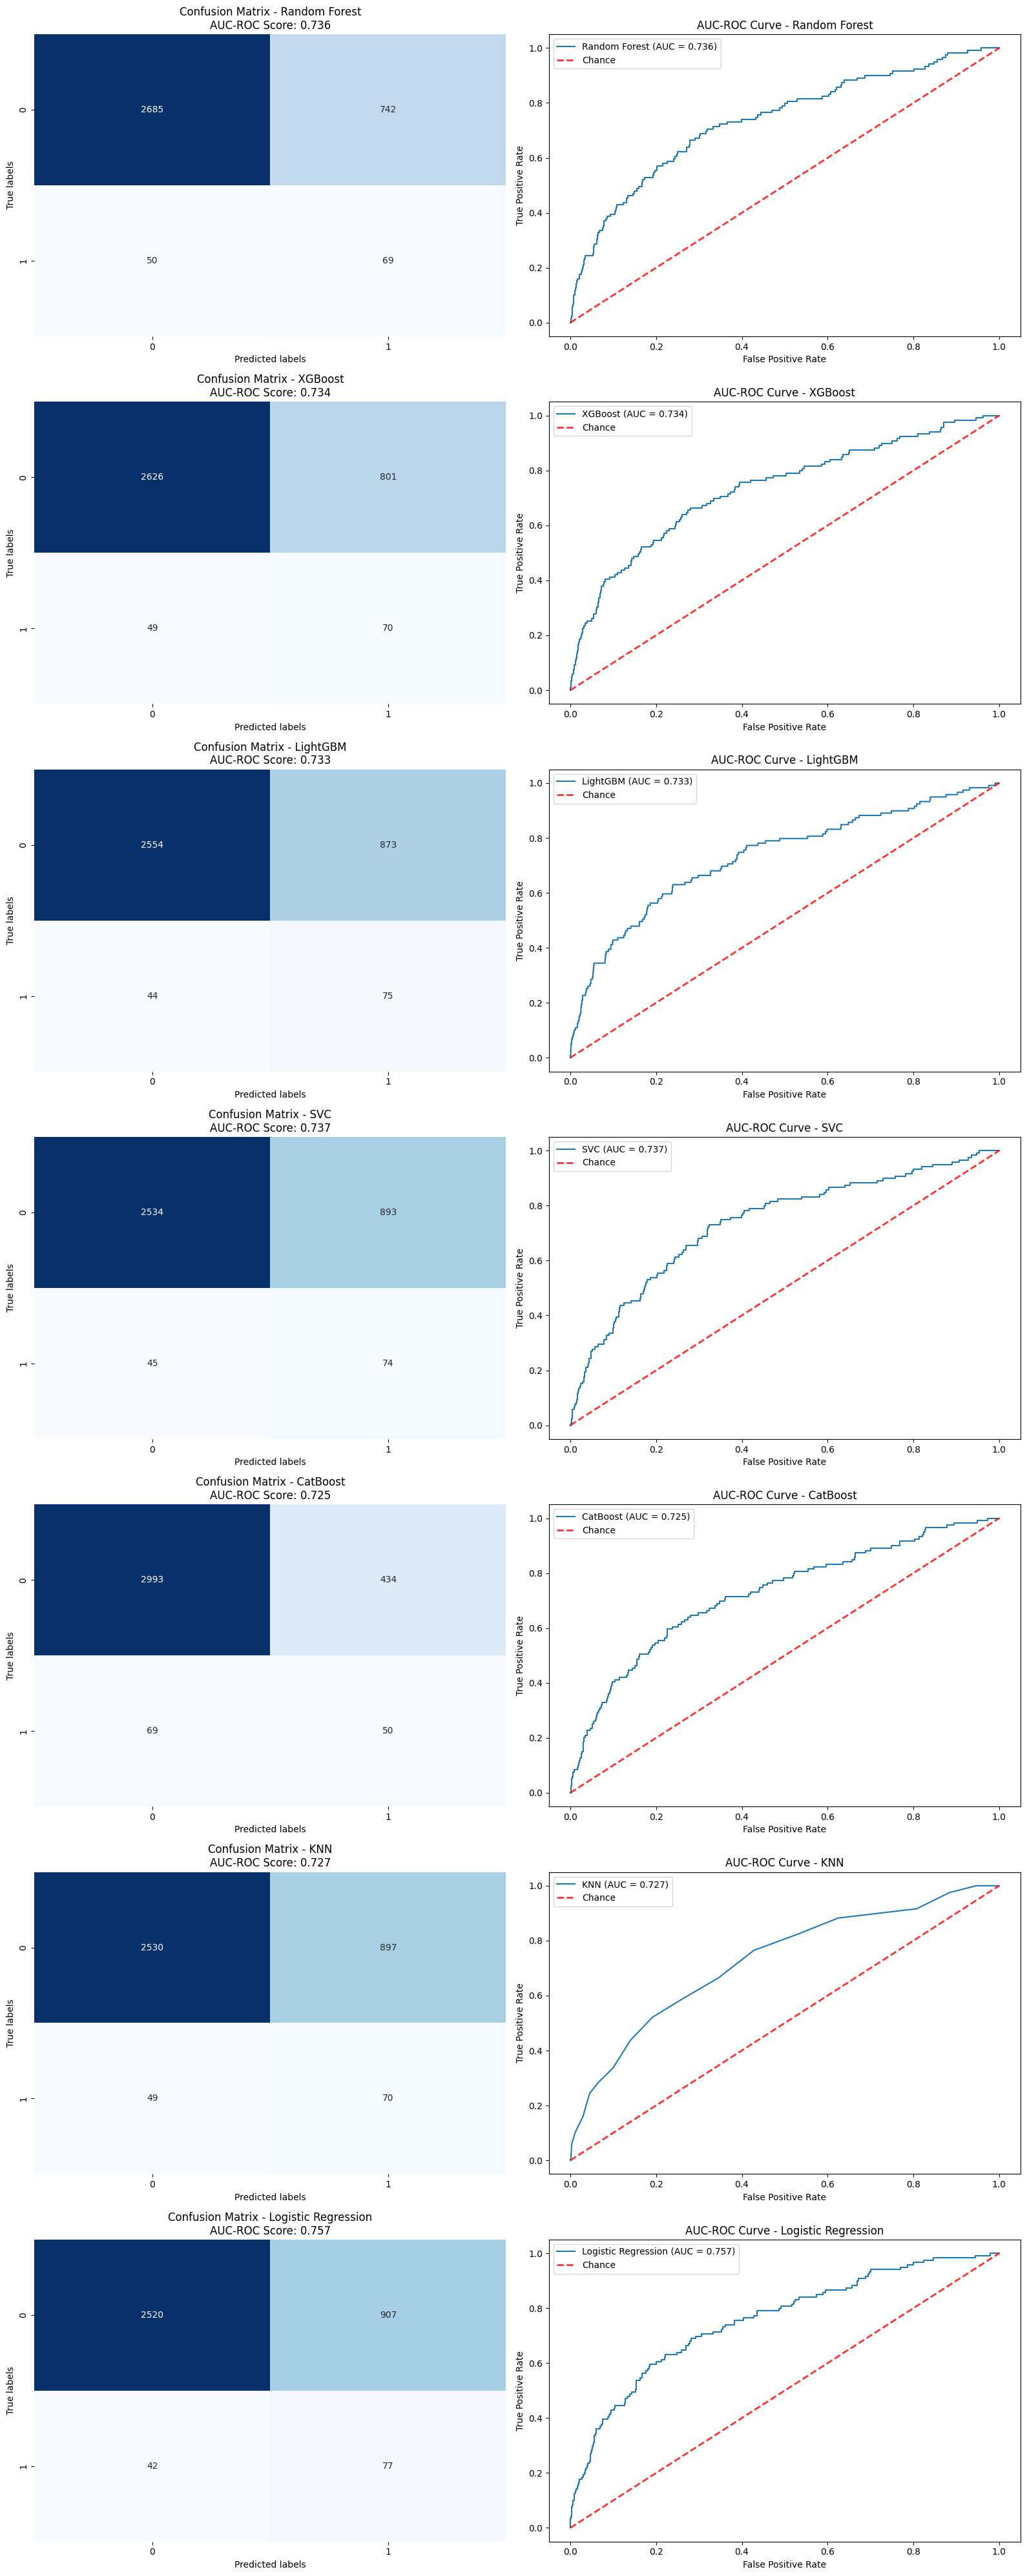


Results Table:


,Model_name,Parameters,CV_score,Test_score
0,Random Forest,"{'max_depth': 8, 'min_samples_split': 10, 'n_e...",0.657535,0.735923
1,XGBoost,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.665136,0.733584
2,LightGBM,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.663094,0.732607
3,SVC,"{'C': 0.9, 'gamma': 'scale'}",0.716495,0.736686
4,CatBoost,"{'auto_class_weights': 'None', 'depth': 6, 'it...",0.663365,0.724837
5,KNN,"{'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}",0.709593,0.726540
6,Logistic Regression,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.733643,0.756957


In [27]:
from sklearn.model_selection import cross_val_score
from IPython.display import display
results = []

plt.figure(figsize=(16, 40))
for i, (name, model) in enumerate(models.items(), 1):
    print(f"\nTraining model: {name}")
    
    # Initialize GridSearchCV with the model and its parameter grid
    if name == 'Random Forest':
        grid_search = GridSearchCV(model, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    elif name == 'XGBoost':
        grid_search = GridSearchCV(model, param_grid_xgb, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    elif name == 'LightGBM':
        grid_search = GridSearchCV(model, param_grid_lgbm, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    elif name == 'SVC':
        grid_search = GridSearchCV(model, param_grid_svc, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    elif name == 'CatBoost':
        grid_search = GridSearchCV(model, param_grid_catboost, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    elif name == 'KNN':
        grid_search = GridSearchCV(model, param_grid_knn, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    elif name == 'Logistic Regression':
        grid_search = GridSearchCV(model, param_grid_logreg, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    
    # Fit GridSearchCV on the down-sampled data
    grid_search.fit(X_resampled, y_resampled)
    
    # Get the best parameters
    best_params = grid_search.best_params_
    
    # Get the best performing model
    best_model = model.set_params(**best_params)
    best_model.fit(X_resampled, y_resampled)
    
    # Calculate AUC-ROC
    y_prob = best_model.predict_proba(X_t_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_t, y_prob)
    auc_roc = roc_auc_score(y_t, y_prob)
    
    # Print classification report
    print("\nClassification Report:")
    y_pred = best_model.predict(X_t_scaled)
    print(classification_report(y_t, y_pred))
    
    # Plot Confusion Matrix
    plt.subplot(7, 2, 2*i-1)
    cm = confusion_matrix(y_t, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {name}\nAUC-ROC Score: {auc_roc:.3f}')
    
    # Plot AUC-ROC Curve
    plt.subplot(7, 2, 2*i)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_roc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUC-ROC Curve - {name}')
    plt.legend()

    # Calculate cross-validated score
    cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=3, scoring='roc_auc')
    cv_score_mean = cv_scores.mean()
    
    # Calculate final test score
    test_score = roc_auc_score(y_t, y_prob)
    
    # Save results to list
    results.append({
        'Model_name': name,
        'Parameters': str(best_params),
        'CV_score': cv_score_mean,
        'Test_score': test_score
    })

plt.tight_layout()
plt.show()

# Create DataFrame from results and display
results_df = pd.DataFrame(results)
print("\nResults Table:")
display(results_df)


In [ ]:
results


Training model: Random Forest

Classification Report with RFECV:
              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87      3427
         1.0       0.09      0.58      0.15       119

    accuracy                           0.78      3546
   macro avg       0.53      0.68      0.51      3546
weighted avg       0.95      0.78      0.85      3546


Training model: XGBoost

Classification Report with RFECV:
              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85      3427
         1.0       0.08      0.64      0.14       119

    accuracy                           0.75      3546
   macro avg       0.53      0.69      0.50      3546
weighted avg       0.95      0.75      0.83      3546


Training model: LightGBM

Classification Report with RFECV:
              precision    recall  f1-score   support

         0.0       0.98      0.73      0.84      3427
         1.0       0.08      0.64      0.14       

CatBoostError: You can't change params of fitted model.

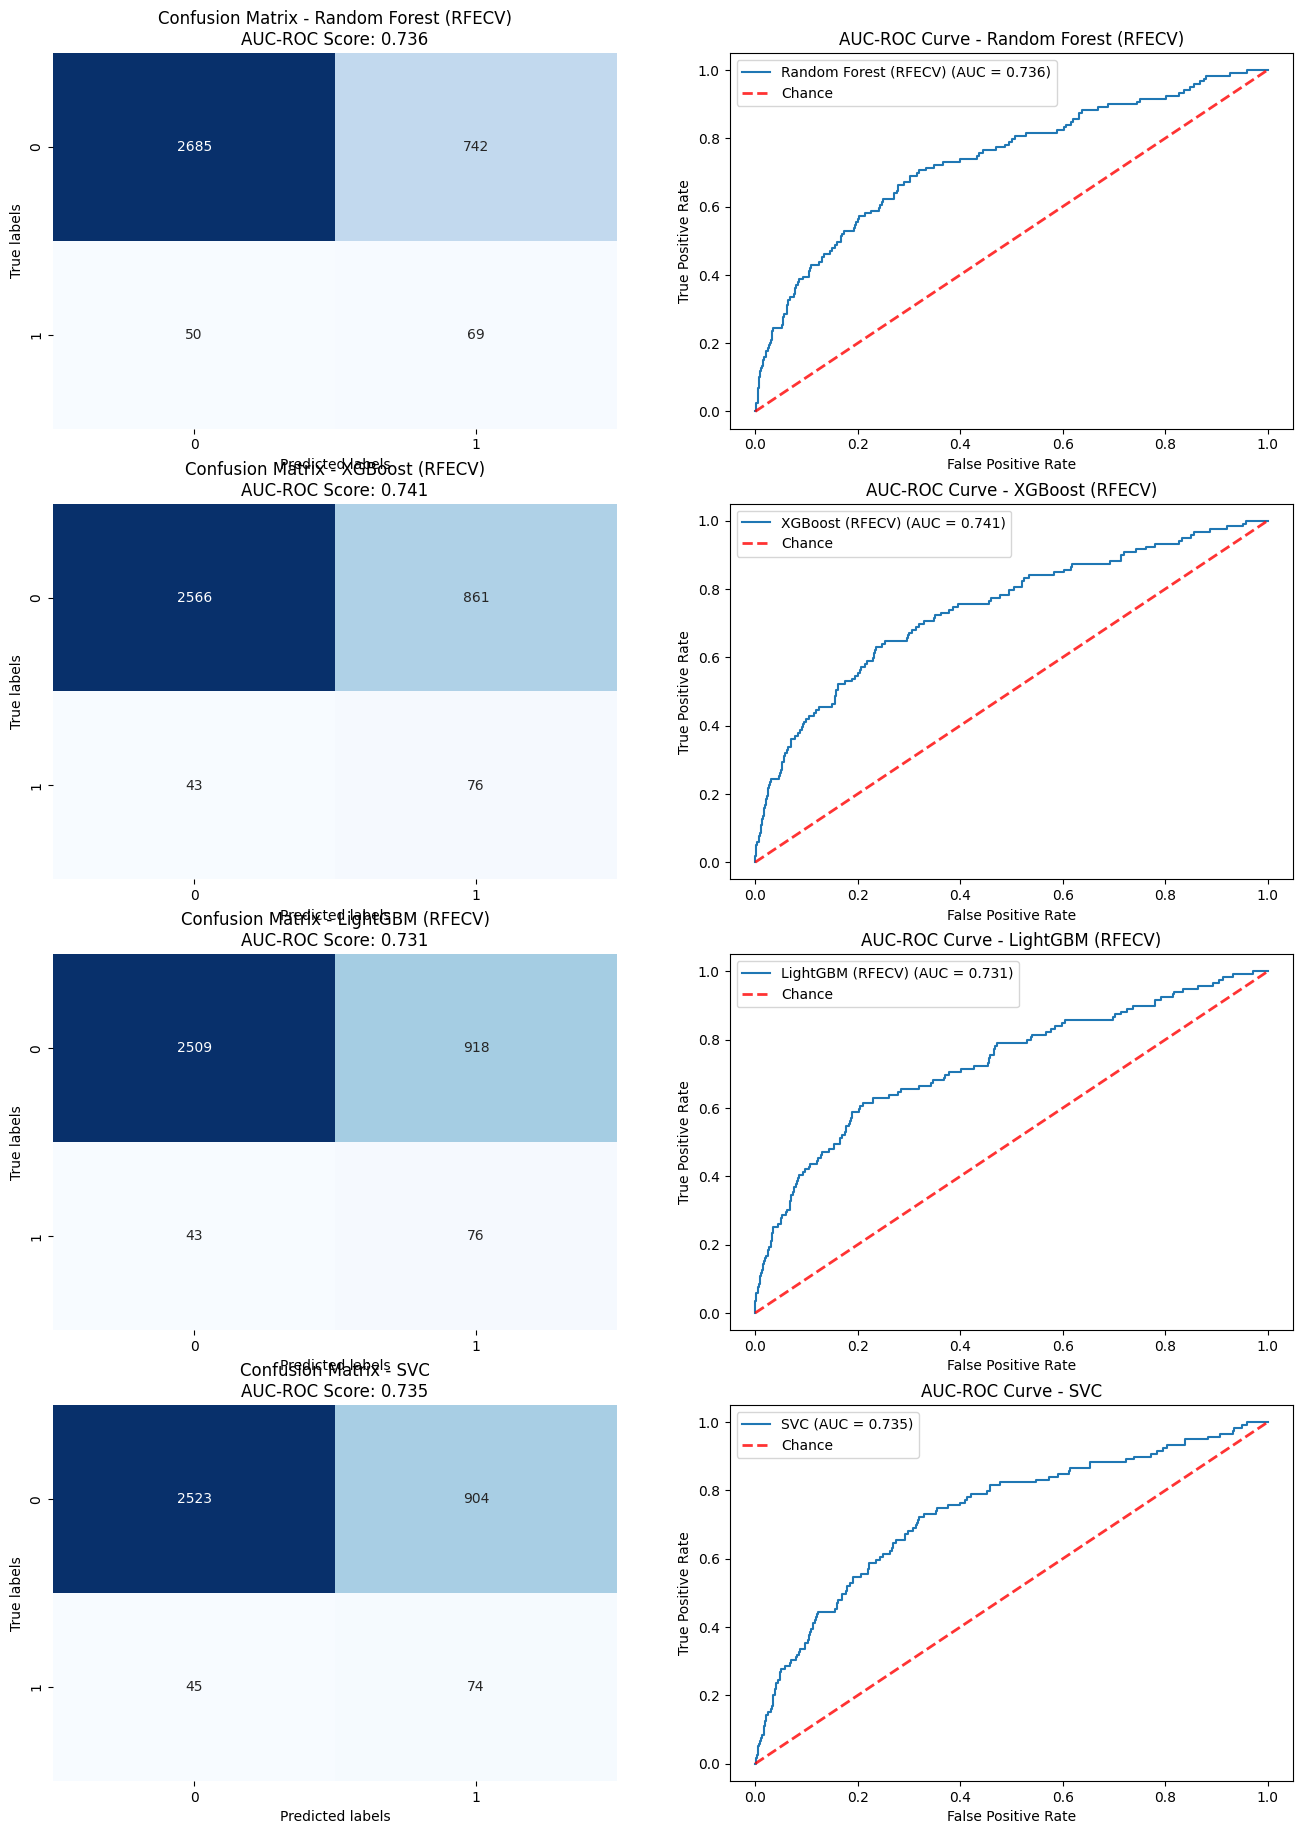

In [12]:
results = []

plt.figure(figsize=(16, 40))
for i, (name, model) in enumerate(models.items(), 1):
    print(f"\nTraining model: {name}")
    
    # Initialize GridSearchCV with the model and its parameter grid
    if name == 'Random Forest':
        grid_search = GridSearchCV(model, param_grid_rf, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    elif name == 'XGBoost':
        grid_search = GridSearchCV(model, param_grid_xgb, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    elif name == 'LightGBM':
        grid_search = GridSearchCV(model, param_grid_lgbm, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    elif name == 'SVC':
        grid_search = GridSearchCV(model, param_grid_svc, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    elif name == 'CatBoost':
        grid_search = GridSearchCV(model, param_grid_catboost, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    elif name == 'KNN':
        grid_search = GridSearchCV(model, param_grid_knn, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    elif name == 'Logistic Regression':
        grid_search = GridSearchCV(model, param_grid_logreg, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    
    # Fit GridSearchCV on the down-sampled data
    grid_search.fit(X_resampled, y_resampled)
    
    # Get the best parameters
    best_params = grid_search.best_params_
    
    # Get the best performing model
    best_model = model.set_params(**best_params)
    
    # If the model is SVC, don't use RFECV
    if name == 'SVC':
        # Fit the model on the down-sampled data
        best_model.fit(X_resampled, y_resampled)
        
        # Calculate AUC-ROC
        y_prob = best_model.predict_proba(X_t_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_t, y_prob)
        auc_roc = roc_auc_score(y_t, y_prob)
        
        # Print classification report
        print("\nClassification Report:")
        y_pred = best_model.predict(X_t_scaled)
        print(classification_report(y_t, y_pred))
        
        # Plot Confusion Matrix
        plt.subplot(7, 2, 2*i-1)
        cm = confusion_matrix(y_t, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'Confusion Matrix - {name}\nAUC-ROC Score: {auc_roc:.3f}')
        
        # Plot AUC-ROC Curve
        plt.subplot(7, 2, 2*i)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_roc:.3f})')
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'AUC-ROC Curve - {name}')
        plt.legend()

        # Calculate cross-validated score
        cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=3, scoring='roc_auc')
        cv_score_mean = cv_scores.mean()
        
        # Calculate final test score
        test_score = roc_auc_score(y_t, y_prob)
        
        # Save results to list
        results.append({
            'Model_name': name,
            'Parameters': str(best_params),
            'CV_score': cv_score_mean,
            'Test_score': test_score
        })
    
    else:
        # Initialize RFECV with manual importance getter
        rfecv = RFECV(estimator=best_model, step=1, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
        
        # Fit RFECV on the training data
        rfecv.fit(X_resampled, y_resampled)
        
        # Get the selected features from RFECV
        X_resampled_rfecv = rfecv.transform(X_resampled)
        X_t_scaled_rfecv = rfecv.transform(X_t_scaled)
        
        # Calculate AUC-ROC
        y_prob_rfecv = best_model.fit(X_resampled_rfecv, y_resampled).predict_proba(X_t_scaled_rfecv)[:, 1]
        fpr_rfecv, tpr_rfecv, _ = roc_curve(y_t, y_prob_rfecv)
        auc_roc_rfecv = roc_auc_score(y_t, y_prob_rfecv)
        
        # Print classification report
        print("\nClassification Report with RFECV:")
        y_pred_rfecv = best_model.predict(X_t_scaled_rfecv)
        print(classification_report(y_t, y_pred_rfecv))
        
        # Plot Confusion Matrix
        plt.subplot(7, 2, 2*i-1)
        cm_rfecv = confusion_matrix(y_t, y_pred_rfecv)
        sns.heatmap(cm_rfecv, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'Confusion Matrix - {name} (RFECV)\nAUC-ROC Score: {auc_roc_rfecv:.3f}')
        
        # Plot AUC-ROC Curve
        plt.subplot(7, 2, 2*i)
        plt.plot(fpr_rfecv, tpr_rfecv, label=f'{name} (RFECV) (AUC = {auc_roc_rfecv:.3f})')
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'AUC-ROC Curve - {name} (RFECV)')
        plt.legend()

        # Calculate cross-validated score
        cv_scores = cross_val_score(best_model, X_resampled_rfecv, y_resampled, cv=3, scoring='roc_auc')
        cv_score_mean = cv_scores.mean()
        
        # Calculate final test score
        test_score = roc_auc_score(y_t, y_prob_rfecv)
        
        # Save results to list
        results.append({
            'Model_name': name,
            'Parameters': str(best_params),
            'CV_score': cv_score_mean,
            'Test_score': test_score
        })

plt.tight_layout()
plt.show()

# Create DataFrame from results and display
results_df = pd.DataFrame(results)
print("\nResults Table:")
display(results_df)